In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, LinearConstraint, NonlinearConstraint, Bounds
import scipy.special
from scipy.stats import binom, multinomial
from tqdm import tqdm

from combinations import combinations_

In [2]:
def get_configuration_chart(m, kappa):
    '''
    Given the edge states, output all the unique configurations they can be
    in (Balls and bins problem)
    '''
    return np.array(combinations_(kappa, m * 2))

def eta(kappa, edge_state_probs):
    '''
    Generate a Bernoulli(1/2) distribution on vertices and edges
    '''
    conf_chart = get_configuration_chart(len(edge_state_probs), kappa)
    return np.vstack([multinomial.pmf(conf_chart, n=kappa, p=np.hstack([edge_state_probs] * 2)/2)/2] * 2)

def Hamiltonian(beta, B, edge_states, C):
    '''
    Generate hamiltonian values corresponding to all unique states
    '''
    m = len(edge_states)
    edge_states = np.array(edge_states)
    vertex_spin_sum = (-C[:, :m] + C[:, m:]) @ edge_states
    return np.vstack([-beta / 2 * vertex_spin_sum - B,
                      beta / 2 * vertex_spin_sum + B])

def relative_entropy(p, q):
    p_divided_by_q = np.divide(p, q, out=np.ones_like(p), where=(p > 0) & (q > 0))
    partial = p * np.log(p_divided_by_q)
    return np.sum(partial)

def edge_distribution(p, kappa, counts, m):
    '''
    Joint distribution for a randomly-chosen edge 
    '''
    # return p @ counts / kappa
    # Equivalent to p @ counts / kappa, but y_0v and x_v are different axes
    return np.stack([p @ counts[:, [i, i+m]] for i in range(m)], axis=-1) / kappa

def multinomial_coeff(params):
    '''
    Calculate the multinomial coefficient
    
    Inputs:
    params: a list, [x1, x2, ..., xk]
    
    Outputs:
    multinomial coefficient {x1 + x2 + ... + xk \choose x1 x2 ... xk}
    '''
    if len(params) == 1:
        return 1
    return scipy.special.binom(sum(params), params[-1]) * multinomial_coeff(params[:-1])

def vertex_distribution(p, kappa, C, m):
    '''
    Joint distribution for all edge-vertex pairs
    
    Input:
    p: 1-d array representing distribution on leaf configurations
    
    Output:
    kappa-d array representing the joint distribution of all edge-vertex pairs
    '''
    # Get the equivalent configuration for each combined vertex-edge state
    def counts(*vertex_marks):
        stacked = np.stack(vertex_marks, axis=0)
        ks = [np.count_nonzero(stacked == l, axis=0) for l in range(2 * m)]
        return np.stack(ks, axis=-1)
    ks = np.fromfunction(counts, [2 * m] * kappa)
    
    # Match the configurations with the ones from configurations list
    k_reshaped = ks.reshape((-1, 2 * m))
    indices = [(conf == C).all(axis=-1).nonzero()[0][0] for conf in k_reshaped]
    
    # Calculate probabilities for each one
    probabilities = [p[index] / multinomial_coeff(C[index]) for index in indices]
    
    return np.array(probabilities).reshape((2 * m,) * kappa)

def objective_function(mu, beta, B, kappa, C, edge_states, edge_state_probs):
    eta_dist = eta(kappa=kappa, edge_state_probs=edge_state_probs)
    hamiltonian = Hamiltonian(beta=beta, B=B, C=C, edge_states=edge_states)
    exp = np.sum(hamiltonian * mu)
    rel_entr = relative_entropy(mu, eta_dist)
    
    m = len(edge_states)
    pi_mu = edge_distribution(mu, kappa=kappa, counts=C, m=m)
    pi_eta = edge_distribution(eta_dist, kappa=kappa, counts=C, m=m)
    marg_rel_entr = relative_entropy(pi_mu, pi_eta)
    return exp - rel_entr + kappa / 2 * marg_rel_entr

edge_states = [-1, 0, 1]
p = 1/3
edge_probs = [.5-.5*p, p, .5-.5*p]
m = len(edge_states)
kappa = 2

C = get_configuration_chart(m, kappa)
print(f'{C=}')
print(f'{C.shape=}')
print(f'{eta(kappa, edge_probs)=}')
print(f'edge_distribution(eta)={edge_distribution(eta(kappa, edge_probs), kappa=kappa, counts=C, m=m)}')
print(f'{Hamiltonian(1, 0, edge_states, C)=}')
ver_dist = vertex_distribution(np.sum(eta(kappa=kappa, edge_state_probs=edge_probs), axis=0), kappa=kappa, C=C, m=m)
print(f'{ver_dist=}')
print(f'{np.sum(ver_dist)=}')

edge_vertex_probs = np.hstack([edge_probs] * 2)/2
print(f'{edge_vertex_probs=}')
print(f'{np.outer(edge_vertex_probs, edge_vertex_probs) - ver_dist}')

C=array([[0, 0, 0, 0, 0, 2],
       [0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 2, 0],
       [0, 0, 0, 1, 0, 1],
       [0, 0, 0, 1, 1, 0],
       [0, 0, 0, 2, 0, 0],
       [0, 0, 1, 0, 0, 1],
       [0, 0, 1, 0, 1, 0],
       [0, 0, 1, 1, 0, 0],
       [0, 1, 0, 0, 0, 1],
       [0, 1, 0, 0, 1, 0],
       [0, 1, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 1, 0],
       [1, 0, 0, 1, 0, 0],
       [0, 0, 2, 0, 0, 0],
       [0, 1, 1, 0, 0, 0],
       [0, 2, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0],
       [1, 1, 0, 0, 0, 0],
       [2, 0, 0, 0, 0, 0]])
C.shape=(21, 6)
eta(kappa, edge_probs)=array([[0.01388889, 0.02777778, 0.01388889, 0.02777778, 0.02777778,
        0.01388889, 0.02777778, 0.02777778, 0.02777778, 0.02777778,
        0.02777778, 0.02777778, 0.02777778, 0.02777778, 0.02777778,
        0.01388889, 0.02777778, 0.01388889, 0.02777778, 0.02777778,
        0.01388889],
       [0.01388889, 0.02777778, 0.01388889, 0.02777778, 0.02777778,
        0.01388889, 0.02777778

In [16]:
def optimize(beta, B, kappa, edge_states, edge_state_probs, mu0=None, C=None, verbose=False, ftol=1e-9, max_iter=1000, project_mu0=False):
    m = len(edge_states)
    assert len(edge_state_probs) == m    
    if C is None:
        C = get_configuration_chart(m, kappa)
    if verbose:
        # print(f'{C=}')
        pass
    num_configurations = len(C)
    
    eta_dist = eta(kappa=kappa, edge_state_probs=edge_state_probs)
    bounds = Bounds(np.zeros_like(eta_dist.flatten()), np.ones_like(eta_dist.flatten()))
    norm_constraint = LinearConstraint(np.ones_like(eta_dist.flatten()), 1, 1)
    admissibility_linear = np.block([[-C[:, y_ind + m], C[:, y_ind]] for y_ind in range(m)]) / kappa
    admissibility_constraint = LinearConstraint(admissibility_linear, lb=0, ub=0)
    
    if mu0 is None:
        mu0 = np.random.uniform(-1, 1, size=eta_dist.shape)
        mu0 = mu0 / np.sum(mu0)
        # Project onto the closest point on the probability simplex
        if project_mu0:
            res = minimize(lambda mu: np.sum((mu - mu0.flatten())** 2) / 2, x0=mu0.flatten(), 
                        method='trust-constr', 
                        constraints=[norm_constraint, admissibility_constraint], 
                        bounds=bounds)
            mu0 = res.x.reshape(2, -1)
            if not res.success:
                print('optimization unsuccessfull')
                print(res)
    
    if verbose:
        print(f'{beta=}, {B=}, {kappa=}\n{mu0=}\n{np.sum(mu0)=}')
    
    res = minimize(lambda mu: -objective_function(mu.reshape(2, num_configurations), beta=beta, B=B, kappa=kappa, C=C, 
                                                  edge_state_probs=edge_state_probs, edge_states=edge_states),
                   x0=mu0.flatten(), method='SLSQP', 
                   constraints=[norm_constraint, admissibility_constraint],
                   bounds=bounds,
                   options={'ftol': ftol, 'disp': verbose, 'maxiter': max_iter})
    
    mu = res.x.reshape(2, num_configurations)
    
    if verbose:
        print(f'objective={objective_function(mu, beta=beta, B=B, kappa=kappa, C=C, edge_states=edge_states, edge_state_probs=edge_state_probs)}\n')
        print(f'mu={mu}\n\n{np.sum(mu)=}\n\n edge_distribution={edge_distribution(mu, kappa=kappa, counts=C, m=m)}')
    
    return mu

In [123]:
# 3 States
edge_states = [-1, 0, 1]
p = 1/2
edge_probs = [.5-.5*p, p, .5-.5*p]

# 4 States
# edge_states = [-3, -1, 1, 3]
# p = 1/5
# edge_probs = [.5-p, p, p, .5-p]

# 5 States
# edge_states = [-2, -1, 0, 1, 2]
# p = 3/8
# q = 2/8
# edge_probs = [.5-.5*p-q, q, p, q, .5-.5*p-q]

# 6 States
# edge_states = [-5, -3, -1, 1, 3, 5]
# p = 3/8
# q = 2/8
# edge_probs = [.5 - p - q, q, p, p, q, .5 - p - q]

m = len(edge_states)
C = get_configuration_chart(m, 2)
print(C)

mu1 = optimize(beta=1, B=0, kappa=2, 
              edge_states=edge_states,
              edge_state_probs=edge_probs,
              verbose=False)
print(objective_function(mu1, 1, 0, 2, C, edge_states, edge_probs))
mu2 = optimize(beta=1, B=0, kappa=2, 
              edge_states=edge_states,
              edge_state_probs=edge_probs,
              verbose=False)
print(objective_function(mu2, 1, 0, 2, C, edge_states, edge_probs))

[[0 0 0 0 0 2]
 [0 0 0 0 1 1]
 [0 0 0 0 2 0]
 [0 0 0 1 0 1]
 [0 0 0 1 1 0]
 [0 0 0 2 0 0]
 [0 0 1 0 0 1]
 [0 0 1 0 1 0]
 [0 0 1 1 0 0]
 [0 1 0 0 0 1]
 [0 1 0 0 1 0]
 [0 1 0 1 0 0]
 [1 0 0 0 0 1]
 [1 0 0 0 1 0]
 [1 0 0 1 0 0]
 [0 0 2 0 0 0]
 [0 1 1 0 0 0]
 [0 2 0 0 0 0]
 [1 0 1 0 0 0]
 [1 1 0 0 0 0]
 [2 0 0 0 0 0]]
0.24022901283604836
0.24022901292729765


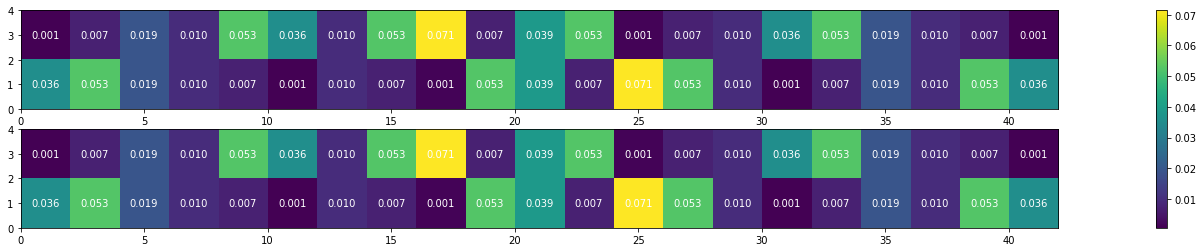

In [124]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(35, 4))
im1 = ax1.imshow(mu1, extent=[0, 2 * mu1.shape[1], 0, 4])
for i in range(mu1.shape[0]):
    for j in range(mu1.shape[1]):
        text = ax1.text(2*j+1, 4 - (2*i+1), f'{mu1[i, j]:.3f}',
                       ha="center", va="center", color="w")
im2 = ax2.imshow(mu2, extent=[0, 2 * mu1.shape[1], 0, 4])
for i in range(mu2.shape[0]):
    for j in range(mu2.shape[1]):
        text = ax2.text(2*j+1, 4 - (2*i+1), f'{mu2[i, j]:.3f}',
                       ha="center", va="center", color="w")
fig.colorbar(im1, ax=[ax1, ax2])

### P(X1, X2 | X0)

In [8]:
edge_states = [-1, 0, 1]
p = 1/3
edge_probs = [.5-.5*p, p, .5-.5*p]
kappa = 2
m = len(edge_states)

C = get_configuration_chart(m, kappa)

mu = optimize(beta=1, B=0, kappa=2, ftol=1e-10, edge_states=edge_states, edge_state_probs=edge_probs, C=C)

x0 = 0
mu_edge = mu[x0] / np.sum(mu, axis=1)[x0]
print(f'{mu_edge=}')
leaf_dist = vertex_distribution(mu_edge, kappa=kappa, C=C, m=m)
leaf_dist = np.sum(leaf_dist, axis=tuple(range(2, kappa)))
print(f'{leaf_dist=}')
p_x1 = np.sum(leaf_dist, axis=1)
p_x2 = np.sum(leaf_dist, axis=0)
print(f'{p_x1=}\n{p_x2=}')
print(f'{np.outer(p_x1, p_x2)=}')

/Users/yizhonghu/anaconda3/lib/python3.8/site-packages/scipy/optimize/_constraints.py:353: OptimizeWarning: Constraint option `keep_feasible` is ignored by this method.
  warn("Constraint option `keep_feasible` is ignored by this "


mu_edge=array([0.00202609, 0.01101651, 0.014972  , 0.02994642, 0.08140157,
       0.11063637, 0.02994611, 0.08140251, 0.22127417, 0.01101563,
       0.02994532, 0.08140116, 0.00405286, 0.0110165 , 0.02994588,
       0.11063871, 0.08140145, 0.01497278, 0.02994625, 0.01101548,
       0.00202621])
leaf_dist=array([[0.00202621, 0.00550774, 0.01497313, 0.01497294, 0.00550825,
        0.00202643],
       [0.00550774, 0.01497278, 0.04070073, 0.04070058, 0.01497266,
        0.00550781],
       [0.01497313, 0.04070073, 0.11063871, 0.11063709, 0.04070126,
        0.01497305],
       [0.01497294, 0.04070058, 0.11063709, 0.11063637, 0.04070079,
        0.01497321],
       [0.00550825, 0.01497266, 0.04070126, 0.04070079, 0.014972  ,
        0.00550826],
       [0.00202643, 0.00550781, 0.01497305, 0.01497321, 0.00550826,
        0.00202609]])
p_x1=array([0.0450147 , 0.12236231, 0.33262396, 0.33262097, 0.12236321,
       0.04501486])
p_x2=array([0.0450147 , 0.12236231, 0.33262396, 0.33262097, 0.12236

In [13]:
betas = np.linspace(-3, 3, 31)
pearson_coeff = []
Bs = [-1, -0.1, 0, .1, 1]

edge_states = [-2, -1, 0, 1, -2]
p = 3/8
q = 1/4
edge_probs = [.5-.5*p-q, q, p, q, .5-.5*p-q]
kappa = 2
num_states = len(edge_states)
C = get_configuration_chart(num_states, kappa)

x0 = 1

res = []

for B, m in zip(Bs, ['o', ':', 'x', '*', '--']):
    mutual_info = []

    for beta in tqdm(betas):
        mu = optimize(beta=beta, B=B, kappa=kappa, ftol=1e-10, C=C,
                      edge_states=edge_states, 
                      edge_state_probs=edge_probs)

        mu_edge = mu[x0] / np.sum(mu, axis=1)[x0]
        
        leaf_dist = vertex_distribution(mu_edge, kappa=kappa, C=C, m=num_states)
        leaf_dist = np.sum(leaf_dist, axis=tuple(range(2, kappa)))
        
        p_x1 = np.sum(leaf_dist, axis=1)
        p_x2 = np.sum(leaf_dist, axis=0)
        indep_dist = np.outer(p_x1, p_x2)

        mutual_info.append(relative_entropy(leaf_dist, indep_dist))
        
    mutual_entropy = np.array(mutual_info)
    res.append(mutual_info)

100%|██████████| 31/31 [09:21<00:00, 18.11s/it]


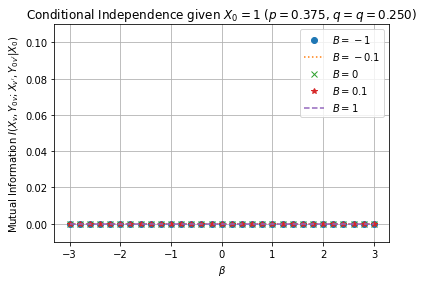

In [14]:
for B, mutual_info, m in zip(Bs, res, ['o', ':', 'x', '*', '--']):
    plt.plot(betas, mutual_info, m, label=f'${B=}$')

    plt.legend()
    plt.title(f'Conditional Independence given $X_0={2*x0-1}$ ($p={p:.3f}$, $q={q=:.3f}$)')
    plt.xlabel('$\\beta$')
    plt.ylabel('Mutual Information $I(X_v, Y_{{0v}}; X_{{v\'}}, Y_{{0v\'}} | X_0)$')
    plt.grid(True)

    plt.ylim((-.01, 0.11))

    plt.savefig(f'../img/EA_x1_x2_x0={2*x0-1}_5s_{p=:.2f}_{q=:.2f}_{kappa=}.png')

### P(X0) with respect to B

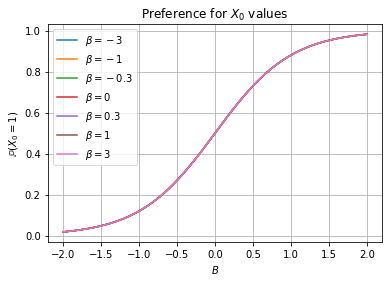

In [61]:
Bs = np.linspace(-2, 2, 51)
betas = [-3, -1, -0.3, 0, 0.3, 1, 3]

for beta in betas:
    probabilities = []
    for B in Bs:
        mu = optimize(beta=beta, B=B, kappa=2, ftol=1e-10)
        probabilities.append(np.sum(mu[1]))
        
    plt.plot(Bs, probabilities, label=f'$\\beta={beta}$')
plt.title('Preference for $X_0$ values')
plt.xlabel('$B$')
plt.ylabel('$\mathbb{P}(X_0=1)$')
plt.grid(True)
plt.legend()
plt.savefig('../img/EA_x0_B.png')

Assume that we have the form
$$\mu(x_0, \tau) = e^{\mathcal{H(x_0, \tau)}}$$
I am guessing that
$$\mu_0(x_0) = \frac1Ze^{f(\beta, B)x_0}$$
Therefore, plotting
$$\log\frac{\mu_0(+)}{1-\mu_0(+)}$$
sounds like a good idea

In [17]:
Bs = np.linspace(-2, 2, 31)
betas = [-1, -.1, 0, 0.1, 1]

edge_states = [-1, 0, 1]
p = 1/2
edge_probs = [.5-.5*p, p, .5-.5*p]
kappa = 4
num_states = len(edge_states)
C = get_configuration_chart(num_states, kappa)

res = []

for beta, m in zip(betas, ['o', ':', 'x', '*', '--']):
    probabilities = []
    for B in tqdm(Bs):
        mu = optimize(beta=beta, B=B, kappa=kappa, ftol=1e-10, C=C,
                      edge_states=edge_states, 
                      edge_state_probs=edge_probs)
        probabilities.append(np.sum(mu[1]))
    
    res.append(np.array(probabilities))

100%|██████████| 31/31 [33:24<00:00, 64.65s/it]


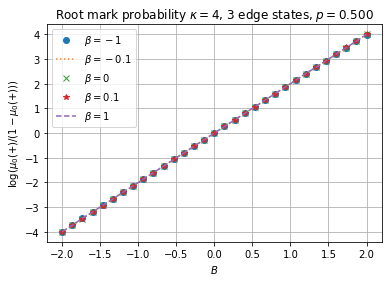

In [18]:
for probabilities, beta, m in zip(res, betas, ['o', ':', 'x', '*', '--']):
    plt.plot(Bs, np.log(probabilities / (1 - probabilities)), m, label=f'$\\beta={beta}$')

plt.title(f'Root mark probability $\\kappa={kappa}$, {len(edge_states)} edge states, $p={p:.3f}$')
plt.xlabel('$B$')
plt.ylabel('$\log(\mu_0(+) / (1-\mu_0(+)))$')
plt.grid(True)
plt.legend()
plt.savefig(f'../img/EA_x0_B_logi_kappa_{kappa}_{len(edge_states)}s_{p=:.2f}_symF.png')

#### Different $\kappa$ values

In [143]:
kappa = 6
B = 2
C = get_configuration_chart(4, kappa=kappa)
mu = optimize(beta=beta, B=B, kappa=kappa, C=C, ftol=1e-10, verbose=True)

C=array([[0, 0, 0, 6],
       [0, 0, 1, 5],
       [0, 0, 2, 4],
       [0, 0, 3, 3],
       [0, 0, 4, 2],
       [0, 0, 5, 1],
       [0, 0, 6, 0],
       [0, 1, 0, 5],
       [0, 1, 1, 4],
       [0, 1, 2, 3],
       [0, 1, 3, 2],
       [0, 1, 4, 1],
       [0, 1, 5, 0],
       [1, 0, 0, 5],
       [1, 0, 1, 4],
       [1, 0, 2, 3],
       [1, 0, 3, 2],
       [1, 0, 4, 1],
       [1, 0, 5, 0],
       [0, 2, 0, 4],
       [0, 2, 1, 3],
       [0, 2, 2, 2],
       [0, 2, 3, 1],
       [0, 2, 4, 0],
       [1, 1, 0, 4],
       [1, 1, 1, 3],
       [1, 1, 2, 2],
       [1, 1, 3, 1],
       [1, 1, 4, 0],
       [2, 0, 0, 4],
       [2, 0, 1, 3],
       [2, 0, 2, 2],
       [2, 0, 3, 1],
       [2, 0, 4, 0],
       [0, 3, 0, 3],
       [0, 3, 1, 2],
       [0, 3, 2, 1],
       [0, 3, 3, 0],
       [1, 2, 0, 3],
       [1, 2, 1, 2],
       [1, 2, 2, 1],
       [1, 2, 3, 0],
       [2, 1, 0, 3],
       [2, 1, 1, 2],
       [2, 1, 2, 1],
       [2, 1, 3, 0],
       [3, 0, 0, 3],
       [3, 

/Users/yizhonghu/anaconda3/lib/python3.8/site-packages/scipy/optimize/_constraints.py:353: OptimizeWarning: Constraint option `keep_feasible` is ignored by this method.
  warn("Constraint option `keep_feasible` is ignored by this "


Iteration limit reached    (Exit mode 9)
            Current function value: -2.6105165493722495
            Iterations: 100
            Function evaluations: 17347
            Gradient evaluations: 100
objective_function(mu, beta=beta, B=B, kappa=kappa, C=C)=2.6105165493722495

mu=array([[4.30172832e-05, 1.85397466e-07, 2.39811504e-06, 3.19520695e-06,
        6.65701751e-06, 1.28296014e-08, 9.58133810e-09, 1.61135813e-05,
        2.76854463e-05, 6.07518560e-06, 9.16484984e-08, 2.76712122e-07,
        1.60204633e-06, 2.94691440e-06, 8.33536504e-07, 5.93769665e-06,
        1.54181612e-05, 5.57954744e-09, 4.18739704e-09, 1.03412352e-04,
        1.90495315e-04, 9.60875021e-05, 7.19344888e-06, 4.09405332e-06,
        5.55888049e-06, 1.13484307e-06, 1.18294163e-06, 5.88666508e-06,
        4.95041732e-06, 1.76974684e-07, 8.02948746e-07, 3.91883753e-07,
        8.75901297e-09, 4.24539354e-12, 1.00269057e-03, 9.45989248e-04,
        2.73175881e-04, 4.92372454e-05, 3.35471835e-05, 3.48754146e-0

In [139]:
Bs = np.linspace(-2, 2, 31)
kappas = [2, 3, 4, 5, 6]
beta = 1

res = []
for kappa, m in zip(kappas, ['o', ':', 'x', '*', '--']):
    probabilities = []
    for B in tqdm(Bs):
        mu = optimize(beta=beta, B=B, kappa=kappa, ftol=1e-10)
        probabilities.append(np.sum(mu[1]))
        
    res.append(probabilities)

100%|██████████| 31/31 [04:39<00:00,  9.02s/it]


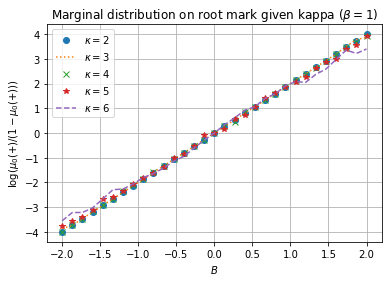

In [146]:
for probabilities, kappa, m in zip(res, kappas, ['o', ':', 'x', '*', '--']):
    probabilities = np.array(probabilities)
    plt.plot(Bs, np.log(probabilities / (1 - probabilities)), m, label=f'$\\kappa={kappa}$')

plt.title(f'Marginal distribution on root mark given kappa ($\\beta={beta}$)')
plt.xlabel('$B$')
plt.ylabel('$\log(\mu_0(+) / (1-\mu_0(+)))$')
plt.grid(True)
plt.legend()
plt.savefig('../img/EA_x0_B_logisitic_change_kappa.png')

In [66]:
A = np.eye(3)
b = np.arange(3)
A + b

array([[1., 1., 2.],
       [0., 2., 2.],
       [0., 1., 3.]])